In [105]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = Path("/home/rjslater/Documents/Projects/UCR6-Stats-Bot/data")

In [126]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")
player_info_df = pd.read_csv(DATA_DIR / "3_tables/player_info.csv")

player_id = "b0e6b1ef-2c4a-4d0b-9f46-1e17aa9a80f7"
player_name = player_info_df[player_info_df["player_id"] == player_id]["player_names"].values[0]

# K/D on map < 60s


In [107]:
kill_df = kill_df[(kill_df["map"] == "Border") & (kill_df["time_seconds"] < 60)]

In [108]:
op_kds = {}  # {"Operator Name": [kills, deaths]}
for _, row in kill_df.iterrows():
    if row["killer_id"] == player_id:
        op = row["killer_operator"]
        if op in op_kds:
            op_kds[op][0] += 1
        else:
            op_kds[op] = [1, 0]
    if row["victim_id"] == player_id:
        op = row["victim_operator"]
        if op in op_kds:
            op_kds[op][1] += 1
        else:
            op_kds[op] = [0, 1]

In [109]:
op_kds_df = pd.DataFrame(op_kds).T
op_kds_df.columns = ["Kills", "Deaths"]
op_kds_df["K/D"] = round(op_kds_df["Kills"] / op_kds_df["Deaths"], 3)
op_kds_df = op_kds_df.sort_values("K/D", ascending=False)

op_kds_df

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [39]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")

kill_times_atk = {}  # {map: [kill_times]}
kill_times_def = {}  # {map: [kill_times]}
death_times_atk = {}  # {map: [death_times]}
death_times_def = {}  # {map: [death_times]}
for _, row in kill_df.iterrows():
    if row["killer_id"] == player_id:
        if row["killer_side"] == "Attack":
            if row["map"] in kill_times_atk:
                kill_times_atk[row["map"]].append(row["time_seconds"])
            else:
                kill_times_atk[row["map"]] = [row["time_seconds"]]
        else:
            if row["map"] in kill_times_def:
                kill_times_def[row["map"]].append(row["time_seconds"])
            else:
                kill_times_def[row["map"]] = [row["time_seconds"]]
    if row["victim_id"] == player_id:
        if row["victim_side"] == "Attack":
            if row["map"] in death_times_atk:
                death_times_atk[row["map"]].append(row["time_seconds"])
            else:
                death_times_atk[row["map"]] = [row["time_seconds"]]
        else:
            if row["map"] in death_times_def:
                death_times_def[row["map"]].append(row["time_seconds"])
            else:
                death_times_def[row["map"]] = [row["time_seconds"]]

# Time of Kills & Deaths by Map Over Time


In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


def seconds_to_mmss(seconds):
    """Convert seconds to MM:SS format."""
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02}:{seconds:02}"


def plot_scatter_with_boxplot(data_dict, title=""):
    """
    Plots a dot scatter plot with an overlaid box-and-whisker plot for each category.

    Args:
        data_dict (dict[str, list[int]]): Dictionary where keys are categories and values are lists of time in seconds.
        title (str): Title for the plot.
    """
    categories = list(data_dict.keys())
    x_positions = range(1, len(categories) + 1)  # Boxplot expects positions starting from 1

    # Use a consistent color palette for categories
    palette = sns.color_palette("husl", len(categories))

    plt.figure(figsize=(10, 6))

    # Overlay scatter plot and box plot
    for x, (category, color) in zip(x_positions, zip(categories, palette)):
        y_values = data_dict[category]

        # Scatter plot points
        plt.scatter([x] * len(y_values), y_values, color=color, alpha=0.7)

        # Box plot for each category
        plt.boxplot(
            [y_values],
            positions=[x],
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5),
            medianprops=dict(color="black"),
            whiskerprops=dict(color=color),
            capprops=dict(color=color),
            flierprops=dict(markeredgecolor=color),
        )

    # Customize x-axis and y-axis
    plt.xticks(x_positions, categories, rotation=45)
    plt.xlabel("Map")
    plt.ylabel("Time")

    # Apply the title if provided
    if title:
        plt.title(title)

    # Format y-axis labels as MM:SS
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: seconds_to_mmss(int(x))))

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    plt.show()

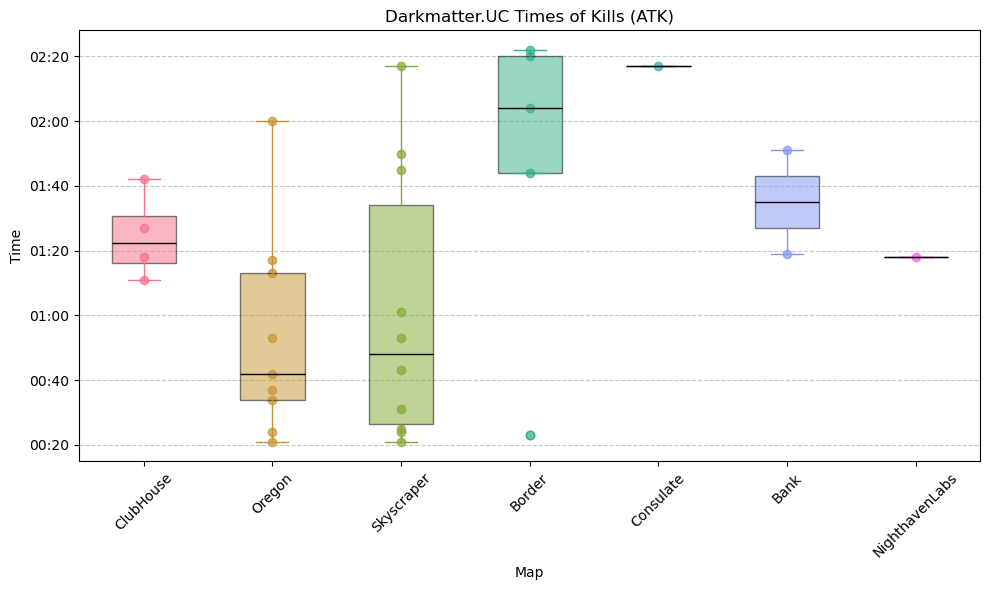

In [41]:
plot_scatter_with_boxplot(kill_times_atk, f"{player_name} Times of Kills (ATK)")

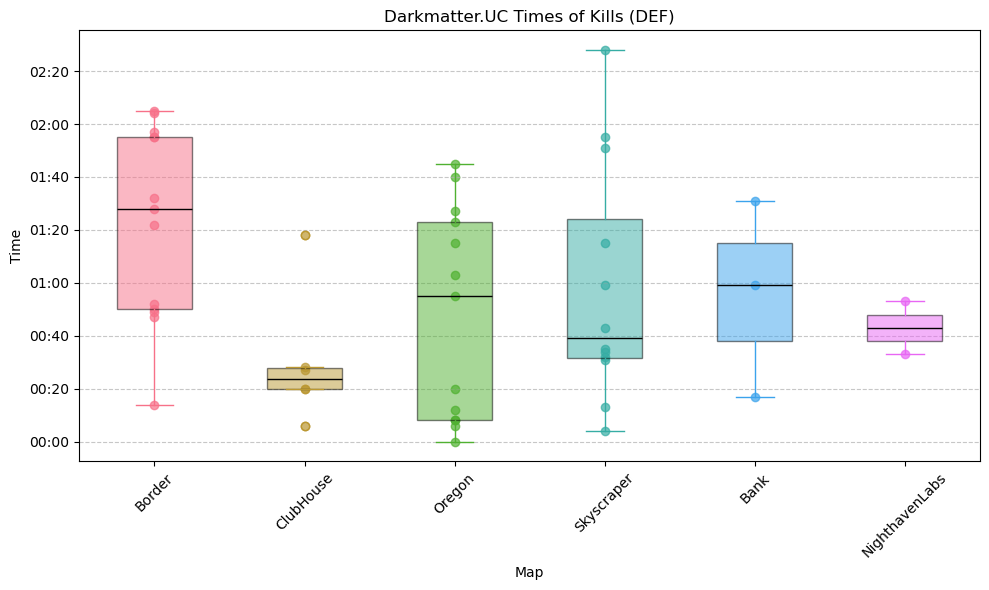

In [42]:
plot_scatter_with_boxplot(kill_times_def, f"{player_name} Times of Kills (DEF)")

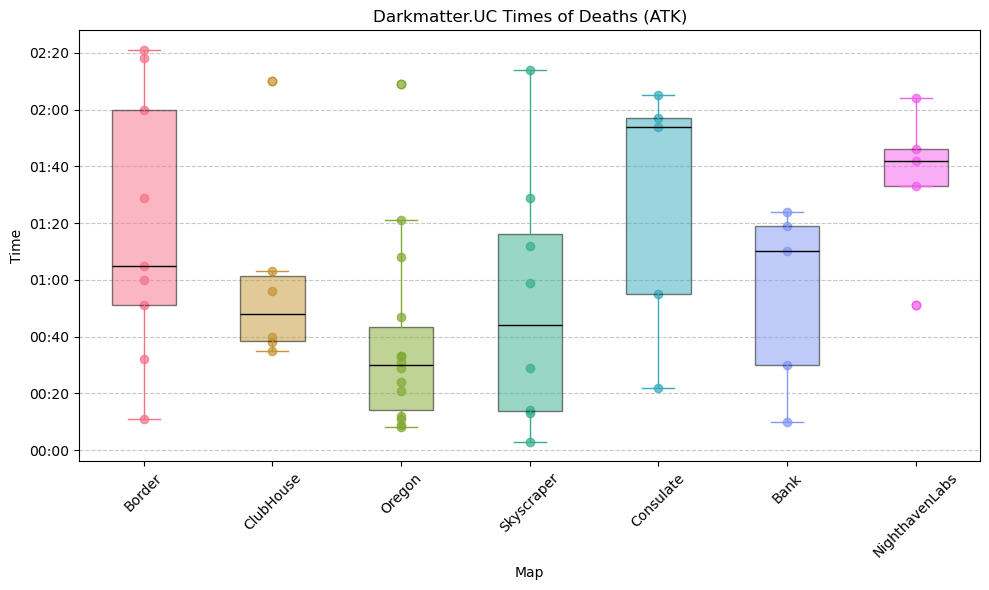

In [43]:
plot_scatter_with_boxplot(death_times_atk, f"{player_name} Times of Deaths (ATK)")

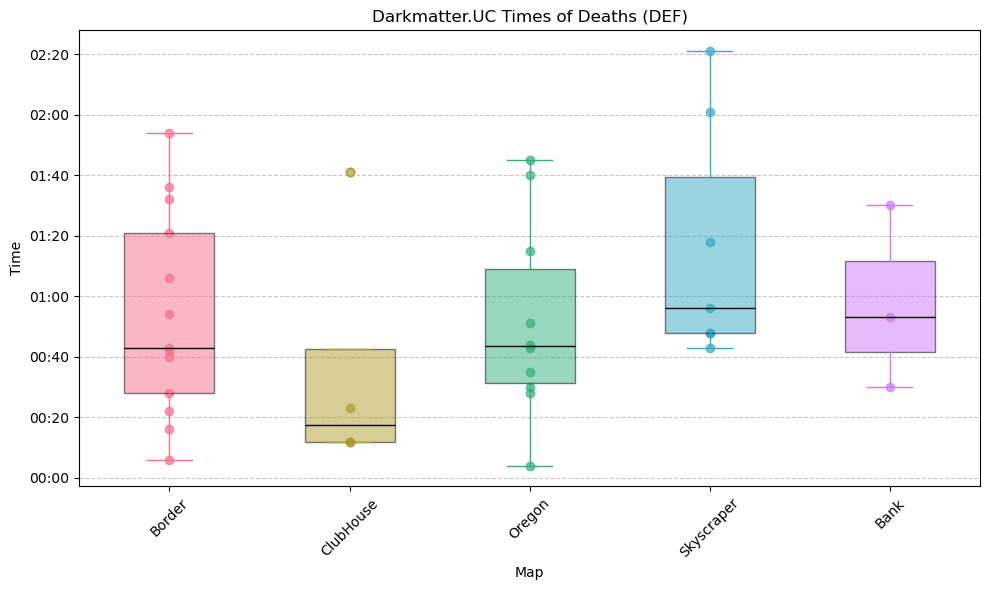

In [44]:
plot_scatter_with_boxplot(death_times_def, f"{player_name} Times of Deaths (DEF)")

# Engagement Efficiency


In [127]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")
kill_df[(kill_df["killer_id"] == player_id) & (kill_df["map"] == "Skyscraper") & (kill_df["time_seconds"] > 140)]

,match_id,round_id,round_num,killer_id,victim_id,headshot,time,time_seconds,map,killer_operator,victim_operator,killer_side,victim_side,killer_spawn,victim_spawn,trade


In [128]:
def seconds_to_mmss(seconds):
    """Convert seconds to MM:SS format."""
    minutes = seconds // 60
    seconds = seconds % 60
    return f"{minutes:02}:{seconds:02}"

In [129]:
def plot_engagements(x_labels, y_labels, heatmap_values, frequency_values, title, max_bullet_size=100):
    """
    Plots a heatmap with bullets overlaid, where:
    - The heatmap is colored from red (lowest values) to green (highest values).
    - The size of the bullet is proportional to the frequency values.
    - The frequency value is displayed on top of the bullet.

    Args:
    - x_labels (array-like): The labels for the x-axis (bins).
    - y_labels (array-like): The labels for the y-axis (bins).
    - heatmap_values (2D array-like): A 2D array of heatmap values.
    - frequency_values (2D array-like): A 2D array of frequency values, where each value determines the size of the bullet.
    - title (str): The title for the plot.
    - max_bullet_size (int): Maximum size of the bullets.
    """

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot the heatmap with 'RdYlGn' colormap (red -> yellow -> green)
    plt.imshow(heatmap_values, cmap="RdYlGn", interpolation="nearest", aspect="auto", origin="lower")

    # Set axis labels
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    plt.yticks(np.arange(len(y_labels)), y_labels)

    # Normalize the frequency values for bullet size scaling
    norm_frequency = (frequency_values - frequency_values.min()) / (frequency_values.max() - frequency_values.min())  # Normalize frequency to [0, 1]
    bullet_sizes = norm_frequency * max_bullet_size  # Scale to the desired maximum bullet size

    # Ensure that the bullets are large enough to fit 3-digit numbers
    max_digits = 3  # Account for 3-digit numbers (100-999)
    bullet_min_size = 200  # Set a minimum bullet size to cover 3-digit text (this can be adjusted)

    bullet_sizes = np.maximum(bullet_sizes, bullet_min_size)  # Make sure no bullet is smaller than the minimum size

    # Overlay bullets using scatter plot (circle markers)
    x_positions, y_positions = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))  # Grid for positions
    scatter = plt.scatter(x_positions, y_positions, s=bullet_sizes.flatten(), c="black", alpha=0.5)  # Bullets overlaid

    # Add frequency value text on top of the bullets (cast to integer)
    for i in range(len(x_labels)):
        for j in range(len(y_labels)):
            frequency_text = str(int(frequency_values[j, i]))  # Cast frequency to integer for display
            plt.text(i, j, frequency_text, color="white", ha="center", va="center", fontsize=10)

    # Add titles and labels
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Map")

    plt.tight_layout()
    plt.show()

In [152]:
def plot_heatmap_with_bullets(heatmap_values, frequency_values, x_labels, y_labels, title="Heatmap", max_bullet_size=300):
    """
    Plots a heatmap where higher values are green, lower values are red, and cells with frequency 0 are white.
    Additionally, gray bullets are plotted above each cell representing the frequency value.

    Parameters:
    - heatmap_values: 2D numpy array of values for coloring the heatmap
    - frequency_values: 2D numpy array of the same size indicating frequency
    - title: Title of the heatmap
    - max_bullet_size: Maximum size of the bullets (adjust for visibility)
    """
    # Ensure inputs are numpy arrays and explicitly convert to integers
    heatmap_values = np.array(heatmap_values, dtype=int)
    frequency_values = np.array(frequency_values, dtype=int)

    # Create a masked array to set white color where frequency is 0
    masked_values = np.ma.masked_where(frequency_values == 0, heatmap_values)

    # Define color palette: Green for high values, Red for low values
    cmap = sns.color_palette("RdYlGn_r", as_cmap=True)  # Reverse "RdYlGn" to make green high, red low

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the heatmap
    sns.heatmap(
        masked_values,
        cmap=cmap,
        annot=True,
        fmt="d",
        linewidths=0.5,
        linecolor="gray",
        cbar=False,  # No colorbar as requested
        mask=frequency_values == 0,  # Mask out zero-frequency cells (they turn white)
        ax=ax,
    )

    # Plot frequency bullets
    rows, cols = frequency_values.shape
    for i in range(rows):
        for j in range(cols):
            freq = frequency_values[i, j]
            if freq > 0:
                ax.scatter(j + 0.5, i + 0.5, s=(freq / frequency_values.max()) * max_bullet_size, color="gray", alpha=0.6)

    # Set the x and y ticks and labels
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)) + 0.5)
    ax.set_xticklabels(x_labels, rotation=45, ha="center")
    ax.set_yticklabels(y_labels, rotation=00, va="center", ha="right")

    # Labels and title
    ax.set_title(title)

    # Show the plot
    plt.show()

In [153]:
def get_engagements_plot_data(kill_data, player_id: str, side: str = "both", time_bin_size: int = 10):
    """
    Generates a heatmap of kill/death ratios for a specific player.

    Args:
    - kill_data (DataFrame): The DataFrame containing the kill data.
    - player_id (str): The ID of the player to analyze.
    - side (str): The side the player is on. Can be "both", "atk", or "def".
    - time_bin_size (int): The size of the time bins in seconds.

    Returns:
    - time_labels (array-like): The labels for the x-axis (time bins).
    - maps (array-like): The labels for the y-axis (maps).
    - heatmap_data (2D array-like): A 2D array of heatmap values (kill/death ratio).
    - frequency_data (2D array-like): A 2D array of frequency values.
    """

    if side == "atk":
        side = "Attack"
    elif side == "def":
        side = "Defense"

    # Filter engagements for the specific player
    engagements_df = kill_data[(kill_data["killer_id"] == player_id) | (kill_data["victim_id"] == player_id)]

    if side != "both":
        engagements_df = engagements_df[
            ((engagements_df["killer_id"] == player_id) & (engagements_df["killer_side"] == side))
            | ((engagements_df["victim_id"] == player_id) & (engagements_df["victim_side"] == side))
        ]

    maps = sorted(engagements_df["map"].unique())

    # Define time bins
    time_bins = np.arange(0, 3 * 60, time_bin_size)  # 10-second time bins
    time_labels = [f"{seconds_to_mmss(time)}-{seconds_to_mmss(time + 10)}" for time in time_bins[:-1]]

    # Initialize arrays for heatmap and frequency data
    heatmap_data = np.zeros((len(maps), len(time_bins) - 1))
    frequency_data = np.zeros((len(maps), len(time_bins) - 1))

    # Loop over each map to fill the data
    for i, map_name in enumerate(maps):
        map_data = engagements_df[engagements_df["map"] == map_name]
        map_time_bins = pd.cut(map_data["time_seconds"], bins=time_bins, labels=False, right=False)

        # Count kills and deaths for each time bin
        kills = np.zeros(len(time_bins) - 1)
        deaths = np.zeros(len(time_bins) - 1)

        for _, row in map_data.iterrows():
            if row["killer_id"] == player_id:
                bin_index = map_time_bins[row.name]
                kills[bin_index] += 1
            elif row["victim_id"] == player_id:
                bin_index = map_time_bins[row.name]
                deaths[bin_index] += 1

        # Compute the kill/death ratio (avoid division by zero)
        with np.errstate(divide="ignore", invalid="ignore"):
            kd_ratio = np.divide(kills, deaths)
            kd_ratio[deaths == 0] = kills[deaths == 0]  # If no deaths, set ratio to kills

        # Store the computed values
        heatmap_data[i] = kd_ratio
        frequency_data[i] = kills + deaths  # Total number of engagements

    # Flip the data horizontally (reverse the rows)
    heatmap_data = np.flip(heatmap_data, axis=1)
    frequency_data = np.flip(frequency_data, axis=1)
    time_labels = time_labels[::-1]

    return time_labels, maps, heatmap_data, frequency_data

[[0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 2. 0. 2. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 2. 0. 0. 1. 0. 0. 1. 2. 1. 1. 2. 1. 1. 0. 0. 0.]]


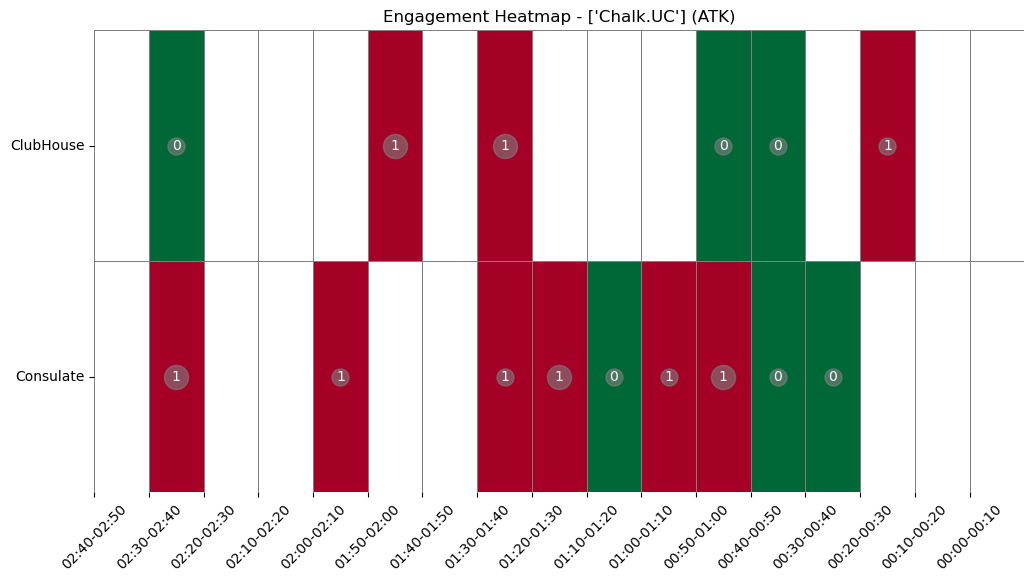

In [155]:
kill_df = pd.read_csv(DATA_DIR / "3_tables/kill_data.csv")

time_labels, maps, heatmap_data, frequency_data = get_engagements_plot_data(kill_df, player_id, "atk")
print(heatmap_data)
print(frequency_data)
plot_heatmap_with_bullets(heatmap_data, frequency_data, time_labels, maps, f"Engagement Heatmap - {player_name} (ATK)")

# plot_engagements(*get_engagements_plot_data(kill_df, player_id, "atk"), f"Engagement Heatmap - {player_name} (ATK)", max_bullet_size=100)
# plot_engagements(*get_engagements_plot_data(kill_df, player_id, "def"), f"Engagement Heatmap - {player_name} (DEF)", max_bullet_size=100)

In [133]:
match_id

'Match-2025-01-28_20-06-55-36144'

In [134]:
player_id

'b0e6b1ef-2c4a-4d0b-9f46-1e17aa9a80f7'

# ===


In [135]:
from utils import player_is_on_team, get_player_name_from_id

In [136]:
match_id = "Match-2025-01-28_20-06-55-36144"
# match_id = "Match-2025-01-28_21-27-26-36144"

team_id = 0

In [137]:
kills = pd.read_csv("/home/rjslater/Documents/Projects/UCR6-Stats-Bot/data/3_tables/kill_data.csv")
kills = kills[kills["match_id"] == match_id]
round_count = max(kills["round_num"])

In [138]:
kill_counts = {}
death_counts = {}
player_ids = [pid for pid in set(kills["killer_id"]) & set(kills["victim_id"]) if player_is_on_team(pid, team_id)]
for player_id in player_ids:
    if player_is_on_team(player_id, team_id):
        kill_counts[player_id] = []
        death_counts[player_id] = []

In [139]:
for round_num in range(1, round_count + 1):
    for player_id in player_ids:
        kill_counts[player_id].append(len(kills[(kills["round_num"] == round_num) & (kills["killer_id"] == player_id)]))
        death_counts[player_id].append(len(kills[(kills["round_num"] == round_num) & (kills["victim_id"] == player_id)]))

In [140]:
kds = {pid: [] for pid in kill_counts}
for player_id in player_ids:
    for i in range(len(kill_counts[player_id])):
        kill_count = sum(kill_counts[player_id][: i + 1])
        death_count = sum(death_counts[player_id][: i + 1])
        if death_count > 0:
            kd = kill_count / death_count
        else:
            kd = kill_count
        kds[player_id].append(kd)

In [141]:
rounds = pd.read_csv("/home/rjslater/Documents/Projects/UCR6-Stats-Bot/data/3_tables/round_data.csv")
rounds = rounds[rounds["match_id"] == match_id]

xticks = []
for round_num in range(1, round_count + 1):
    kill_data = kills[kills["round_num"] == round_num].iloc[0]
    if player_is_on_team(kill_data["killer_id"], team_id):
        side = "ATK" if kill_data["killer_side"] == "Attack" else "DEF"
    else:
        side = "ATK" if kill_data["victim_side"] == "Attack" else "DEF"

    round_data = rounds[rounds["round_num"] == round_num].iloc[0]
    site = round_data["site"]
    xtick = f"R{round_num} {side} {site.split(' ')[1]}".removesuffix(",")
    xticks.append(xtick)
    print(xtick)

R1 ATK Bedroom
R2 ATK Bedroom
R3 ATK Church
R4 ATK Church
R5 ATK Cash
R6 ATK Cash
R7 DEF Bedroom
R8 DEF Bedroom
R9 DEF Church
R10 DEF Church
R11 DEF Bar
R12 DEF Bar


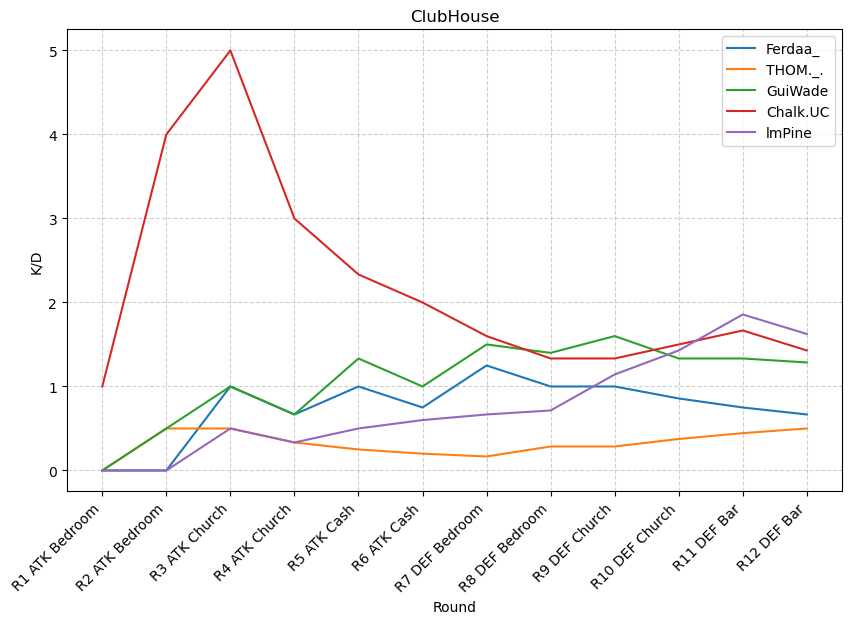

In [142]:
plt.figure(figsize=(10, 6))

for player_id, kd_values in kds.items():
    plt.plot(kd_values, label=get_player_name_from_id(player_id))  # Plot each list with markers

map_name = kills[kills["match_id"] == match_id].iloc[0]["map"]
plt.title(map_name)
plt.xlabel("Round")
plt.ylabel("K/D")
plt.xticks(ticks=range(len(xticks)), labels=xticks, rotation=45, ha="right")
plt.legend()  # Show legend for keys
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()